# **Global settings**

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib import rcParams
from matplotlib.pyplot import rc_context
import scanpy as sc
import scrublet as scr
import scvelo as scv
import seaborn as sns
import scipy.io
import os
import dotplot
import dotplot.utils
import math
import gseapy as gp
from gseapy.plot import barplot, dotplot, gseaplot
from gseapy.scipalette import SciPalette
from pylab import *
from matplotlib.colors import ListedColormap,LinearSegmentedColormap 

In [2]:
sc.settings.set_figure_params(dpi=100, dpi_save=300, figsize=(5, 5))

In [ ]:
plt.set_cmap('viridis')

In [4]:
scv.set_figure_params()

In [5]:
os.chdir('/disk213/xieqq/JINHUA138.sc')

# **CellLineage**

## **scrublet**

In [ ]:
output_file = 'Sample_1_SI_0_doublet.png'
input_dir = '/disk213/xieqq/sc/filtered_feature_bc_matrix/Sample_1_SI_0'
os.chdir(input_dir)

counts_matrix = scipy.io.mmread(input_dir + '/matrix.mtx').T.tocsc()
genes = np.array(scr.load_genes(input_dir + '/features.tsv', delimiter='\t', column=1))
out_df = pd.read_csv(input_dir + '/barcodes.tsv', header = None, index_col=None, names=['barcode'])

#print('Counts matrix shape: {} rows, {} columns'.format(counts_matrix.shape[0], counts_matrix.shape[1]))
#print('Number of genes in gene list: {}'.format(len(genes)))

In [ ]:
scrub = scr.Scrublet(counts_matrix, expected_doublet_rate=0.06)

In [ ]:
doublet_scores, predicted_doublets = scrub.scrub_doublets(min_counts=2, min_cells=3, min_gene_variability_pctl=85, n_prin_comps=30)

In [ ]:
scrub.call_doublets(threshold=0.25)

In [ ]:
scrub.plot_histogram()
plt.savefig(output_file,dpi=1000)

In [ ]:
out_df['doublet_scores'] = doublet_scores
out_df['predicted_doublets'] = predicted_doublets
out_df.to_csv(input_dir + '/doublet.txt', index=False,header=True)

## **standardized and concat**

In [ ]:
PATH='/disk213/xieqq/JINHUA138.sc/filtered_feature_bc_matrix/'
mtgene=pd.read_csv("/disk212/yupf/database/scRNA-seq/NewAtlas/mtgene.csv")
ap={}
sample=['Sample_1_SI_0','Sample_2_SI_0','Sample_3_SI_0','Sample_4_SI_60','Sample_5_SI_60',
        'Sample_6_SI_60','Sample_7_SI_90','Sample_8_SI_90','Sample_9_SI_90','Sample_10_SI_180',
        'Sample_11_SI_180','Sample_12_SI_180','Sample_13_SI_240','Sample_14_SI_240','Sample_15_SI_240',
        'Sample_16_LI_0','Sample_17_LI_0','Sample_18_LI_60','Sample_19_LI_60','Sample_20_LI_90',
        'Sample_21_LI_90','Sample_22_LI_180','Sample_23_LI_180','Sample_24_LI_240','Sample_25_LI_240']

for i in sample:
    ap[f'{i}']=sc.read_10x_mtx(PATH+f'{i}')
    ap[f'{i}'].var_names_make_unique
    scrublets=pd.read_csv(PATH+f'{i}'+'/doublet.txt',index_col='barcode')
    ap[f'{i}'].obs['doublet_scores']=scrublets['doublet_scores']
    ap[f'{i}'].obs['predicted_doublets']=scrublets['predicted_doublets']
    x=['{}',f'{i}']
    ap[f'{i}'].obs.index=ap[f'{i}'].obs.index.map('_'.join(x).format)
    
    sc.pp.filter_cells(ap[f'{i}'], min_genes=200)
    sc.pp.filter_genes(ap[f'{i}'], min_cells=3)
    # ap[f'{i}'].var['mt'] = ap[f'{i}'].var_names.str.startswith('MT')   #annotate the group of mitochondrial genes as 'mt'
    ap[f'{i}'].var['mt'] = ap[f'{i}'].var_names.isin(mtgene['MT-genes'])
    sc.pp.calculate_qc_metrics(ap[f'{i}'], qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)
    # sc.pl.violin(ap[f'{i}'],["n_genes_by_counts", "total_counts", "pct_counts_mt"],jitter=0.1,multi_panel=True,show=False,save='_'+i+'_QC.pdf')
    
    ap[f'{i}'] = ap[f'{i}'][ap[f'{i}'].obs.n_genes_by_counts < 7500, :]
    ap[f'{i}'] = ap[f'{i}'][ap[f'{i}'].obs.n_genes_by_counts > 200, :]
    ap[f'{i}'] = ap[f'{i}'][ap[f'{i}'].obs.pct_counts_mt < 50, :]

In [ ]:
sc.pl.violin(ap['Sample_25_LI_240'],["n_genes_by_counts", "total_counts", "pct_counts_mt"],jitter=0.1,multi_panel=True)

In [ ]:
adata=sc.concat(ap.values(),keys=ap.keys(),label='PRO1_JH')
adata

In [ ]:
sc.pl.violin(adata,["n_genes_by_counts", "total_counts", "pct_counts_mt"],jitter=False,stripplot=False, multi_panel=True,save='_afterQC.pdf')

In [142]:
adata.write('adata_rowcounts.h5ad')

In [145]:
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)
sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5)

adata.raw = adata
adata = adata[:, adata.var.highly_variable]
    
sc.tl.pca(adata, svd_solver='arpack')
sc.pp.neighbors(adata, n_neighbors=10, n_pcs=40)
sc.tl.umap(adata)

adata = adata.raw.to_adata()

In [ ]:
mtgene=pd.read_csv("/disk212/yupf/database/scRNA-seq/NewAtlas/mtgene.csv")
# mitochondrial genes, "MT-" for human, "Mt-" for mouse
adata.var["mt"] = adata.var_names.isin(mtgene['MT-genes'])
# ribosomal genes
adata.var["ribo"] = adata.var_names.str.startswith(("RPS", "RPL"))
# hemoglobin genes
adata.var["hb"] = adata.var_names.str.contains("^HB[^(P)]")

sc.pp.calculate_qc_metrics(adata, qc_vars=["mt", "ribo", "hb"], inplace=True, log1p=True)
sc.pl.violin(adata,["n_genes_by_counts", "total_counts", "pct_counts_mt"],jitter=0.1,multi_panel=True)

In [ ]:
sc.tl.pca(adata, svd_solver='arpack')
sc.pl.pca_variance_ratio(adata, log=True, n_pcs=50)

In [ ]:
sc.external.pp.harmony_integrate(adata, 'BATCH', basis='X_pca', adjusted_basis='X_pca_harmony')

In [ ]:
sc.pp.neighbors(adata, use_rep="X_pca_harmony")

In [13]:
sc.tl.umap(adata, min_dist=0.1)

In [ ]:
sc.tl.tsne(adata,use_rep="X_pca_harmony")

In [15]:
sc.tl.leiden(adata)

In [ ]:
for i in range(1,10):
    sc.tl.leiden(adata,resolution=round(i*0.1,1),key_added=f'cluster_{round(i*0.1,1)}')
sc.pl.umap(adata,color=[f'cluster_{round(i*0.1,1)}'for i in range(1,10)],ncols=2,wspace=0.5)

In [18]:
adata.write('adata_concat.h5ad')

## **marker gene**

In [7]:
adata=sc.read_h5ad('adata_concat.h5ad')

In [ ]:
sc.tl.leiden(adata,resolution=0.4,key_added='cluster_0.4')
sc.pl.umap(adata,color=['cluster_0.4'],legend_loc='on data')

In [ ]:
GENE = ['EPCAM','KRT8','ELF3','SLC44A4']
sc.pl.umap(adata,color=GENE)  # epithelial cell genes
sc.pl.violin(adata, keys=GENE, groupby='cluster_0.4')

In [ ]:
GENE = ['JCHAIN','MZB1','DERL3']
sc.pl.umap(adata,color=GENE)  #plasma cell genes
sc.pl.violin(adata, keys=GENE, groupby='cluster_0.4')

In [ ]:
GENE = ['CD19','CD79A','CD79B','SMC6','PAX5','MEF2C','POU2AF1']
sc.pl.umap(adata,color=GENE)  #B cell genes
sc.pl.violin(adata, keys=GENE, groupby='cluster_0.4')

In [ ]:
GENE = ['CD3D','CD3E','CD4','CD8A','PRF1','NKG7','ZAP70','PRF1','CD2','CST7']
sc.pl.umap(adata,color=GENE) #T/ILC/NK cell genes
sc.pl.violin(adata, keys=GENE, groupby='cluster_0.4')

In [ ]:
GENE = ['STMN1','TUBB','STMN1','PTMA','RPS20','RPL37','RPS15A']
sc.pl.umap(adata,color=GENE) #neuronal cell
sc.pl.violin(adata, keys=GENE, groupby='cluster_0.4')

In [ ]:
GENE = ['PECAM1','CLDN5','HEY1','EFNB2','PROX1','APOA1','TIMP3','ICAM1']
sc.pl.umap(adata,color=GENE)  #endothelial cell
sc.pl.violin(adata, keys=GENE, groupby='cluster_0.4')

In [ ]:
GENE = ['ZEB2','BMP4','MMP3','CALD1']
sc.pl.umap(adata,color=GENE) #mesenchymal cell
sc.pl.violin(adata, keys=GENE, groupby='cluster_0.4')

In [ ]:
GENE = ['CD163','C1QB','C1QC','CD163','CD68','AIF1','TYROBP','FCER1A']
sc.pl.umap(adata,color=GENE)  #myeloid lineage
sc.pl.violin(adata, keys=GENE, groupby='cluster_0.4')

In [ ]:
def function(a):
    if a in ['0','1','5','7','8','11','12','16','17','18','19','20','21','22']:
        return 'Epithelial' 
    elif a in ['3','6']:
        return "Bcells"
    elif a in ['13']:
        return "Neuronal"
    elif a in ['9']:
        return "Plasma" 
    elif a in ['2','4']:
        return "T_ILC_NKcells"
    elif a in ['10','14']:
        return "Myeloid"
    elif a in ['15']:
        return "mass"
adata.obs["CellLineage"]=adata.obs.apply(lambda x: function(x['cluster_0.4']),axis=1) 

In [45]:
mass = adata[adata.obs['CellLineage'].isin(['mass'])]

In [ ]:
sc.tl.leiden(mass)
sc.pl.umap(mass,color=['leiden'],legend_loc='on data')

In [47]:
sc.tl.leiden(mass,resolution=0.1,key_added='cluster_0.1')

In [ ]:
sc.pl.umap(mass,color=['cluster_0.1'],legend_loc='on data')

In [ ]:
#endothelial cell
sc.pl.umap(mass,color=['PECAM1','CLDN5','HEY1','EFNB2','PROX1','APOA1','TIMP3','ICAM1'])

In [ ]:
#mesenchymal cell
sc.pl.umap(mass,color=['ZEB2','BMP4','MMP3','CALD1'])

In [ ]:
def function(a):
    if a in ['1']:
        return "Mesenchymal"
    elif a in ['0']:
        return "Endothelial"
df = mass.obs
df["CellLineage"] = df.apply(lambda x: function(x['cluster_0.1']),axis=1) 

In [50]:
adata.obs['CellLineage'] = adata.obs['CellLineage'].cat.add_categories('Endothelial')
adata.obs['CellLineage'] = adata.obs['CellLineage'].cat.add_categories('Mesenchymal')

In [51]:
adata.obs.loc[mass.obs_names,'CellLineage'] = mass.obs['CellLineage']

In [52]:
adata.obs['CellLineage'] = adata.obs['CellLineage'].cat.remove_unused_categories()

In [59]:
CellLineage_newcolors = ['#1b9e77','#7570b3','#EE9B00','#CA6702','#6699CC','#FF220C','#e7298a','#6F5E5C']

In [ ]:
sc.pl.umap(adata, color=['CellLineage'], palette=CellLineage_newcolors, save='_CellLineage.pdf')

In [62]:
adata.write('adata_CellLineage.h5ad')

## **Cell ratio (cell lineages)**

In [6]:
adata=sc.read_h5ad('adata_CellLineage.h5ad')

In [ ]:
times = ['small-0', 'small-60', 'small-90', 'small-180', 'small-240',
         'large-0', 'large-60', 'large-90', 'large-180', 'large-240']
categories = adata.obs['CellLineage'].cat.categories.tolist()
histogram_dict = {}
for time in times:
    histogram_data = adata[adata.obs['INTESTINAL-TIME'].isin([time])]
    histogram_count = histogram_data.obs.groupby(['CellLineage'])['INTESTINAL-TIME'].count()
    histogram_count = histogram_count.reindex(categories, fill_value=0)
    histogram_dict[time] = histogram_count

In [ ]:
list1 = []
for time in times:
    list1.append(histogram_dict[time])
list1 = np.array(list1)
print(list1)

In [ ]:
# Relative proportions of cell lineages at each developmental stage
xlabels = times
ylabels = ['0','20','40','60','80','100']
cell1 = np.array(list1[:,0])
cell2 = np.array(list1[:,1])
cell3 = np.array(list1[:,2])
cell4 = np.array(list1[:,3])
cell5 = np.array(list1[:,4])
cell6 = np.array(list1[:,5])
cell7 = np.array(list1[:,6])
cell8 = np.array(list1[:,7]) 
data = [cell1, cell2, cell3, cell4, cell5, cell6, cell7, cell8]
legend = categories

x = range(len(xlabels))
width = 0.6
bottom_y = np.zeros(len(xlabels))
data = np.array(data)
sums = np.sum(data, axis=0)

plt.figure(figsize=(15, 4))
for i in range(len(data)):
    colorbar = CellLineage_newcolors[i]
    y = data[i] / sums
    plt.bar(x, y, width, bottom=bottom_y, color=colorbar)
    bottom_y = y + bottom_y
ax=plt.gca()
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.grid(False)
plt.legend(frameon=False,bbox_to_anchor=(1.01,1), fancybox=True, ncol=1, labels=legend)
plt.ylabel("Proportion of total (%)")
plt.xticks(x, xlabels, rotation=90)
plt.yticks([0,0.2,0.4,0.6,0.8,1], ylabels)
plt.savefig('./figures/histogram_CellLineage_all.pdf', bbox_inches='tight')
plt.show()

## *top/marker gene*

In [ ]:
adata.uns['log1p']["base"] = None

In [66]:
sc.tl.rank_genes_groups(adata, groupby='CellLineage_change_categories', method='wilcoxon', n_genes=20, key_added='rank_genes_groups_CellLineage')

In [ ]:
result = adata.uns['rank_genes_groups_CellLineage']
groups = result['names'].dtype.names
marker=pd.DataFrame(
    {group + '_' + key[:1]: result[key][group]
    for group in groups for key in ['names', 'pvals','logfoldchanges','scores']})
marker.to_csv("/disk213/xieqq/JINHUA138.sc/Top_Marker_Gene/rank_genes_groups_CellLineage.csv")

In [72]:
adata.write('adata_CellLineage_rank_genes_groups.h5ad')

In [70]:
sc.tl.rank_genes_groups(adata, groupby='CellLineage_change_categories', method='wilcoxon', corr_method='benjamini-hochberg', n_genes=500, key_added='DEG')

result = adata.uns['DEG']
groups = result['names'].dtype.names
marker=pd.DataFrame(
    {group + '_' + key[:1]: result[key][group]
    for group in groups for key in ['names', 'pvals','logfoldchanges','scores']})

marker.to_csv("/disk213/xieqq/JINHUA138/Single_cell_analysis.10.LDSC/DEG_CellLineage.csv")

In [7]:
adata=sc.read_h5ad('adata_CellLineage_rank_genes_groups.h5ad')

In [ ]:
sc.pl.rank_genes_groups_dotplot(adata, n_genes=5, key='rank_genes_groups_CellLineage',standard_scale='var', cmap='Blues')

In [31]:
marker_genes_dict = {
    'Epithelial':['EPCAM','KRT8','ELF3','SLC44A4'],
    'T_ILC_NK cells': ['CD3D','CD3E','CD4','CD8A','PRF1','NKG7','ZAP70','PRF1','CD2','CST7'],
    'B cells': ['CD19','CD79A','CD79B','SMC6','PAX5','MEF2C','POU2AF1'],
    'Plasma':['JCHAIN','MZB1','DERL3'],
    'Neuronal':['STMN1','TUBB','STMN1','PTMA','RPS20','RPL37','RPS15A'],
    'Mesenchymal':['ZEB2','BMP4','MMP3','CALD1'],
    'Endothelial':['PECAM1','CLDN5','HEY1','EFNB2','PROX1','APOA1','TIMP3','ICAM1'],
    'Myeloid':['CD163','C1QB','C1QC','CD163','CD68','AIF1','TYROBP','FCER1A']
}

In [ ]:
sc.pl.rank_genes_groups_dotplot(adata, var_names=marker_genes_dict, key='rank_genes_groups_CellLineage', standard_scale='var', cmap='Blues', save='CellLineage_MarkerGene.pdf')

## **Merge layers**

In [109]:
adata=sc.read_h5ad('adata_CellLineage.h5ad')
Epithelial=sc.read_h5ad('Epithelial_CellType.h5ad')
Plasma_Bcells=sc.read_h5ad('Plasma_Bcells_CellType.h5ad')
T_ILC_NKcells=sc.read_h5ad('T_ILC_NKcells_CellType.h5ad')

In [110]:
adata.obs['CellType']=adata.obs['CellLineage']
celltypes=['Enterocytes','Colonocytes','BEST4enterocytes','EECs','Tuft','Goblet','Progenitor','TA','Stem',
           'Cycling B cells','Activated B cells','Transitioning B cells','Resting B cells',
           'Naive CD4+ T cells','CD4+ T follicular helper cells','CD4+ T regulatory cells','CD4+ T memory cells','Naive CD8+ T cells','Non-naive CD8+ T cells','CD8+ T cytotoxic cells',
           'CD8+ T regulatory cells','CD8+ T memory cells','Non-naive γδ T cells','γδ T cytotoxic cells','Group 1 ILCs','Group 2 ILCs','Group 3 ILCs','NK cells']
for celltype in celltypes:
    adata.obs['CellType']=adata.obs['CellType'].cat.add_categories(celltype)

mapping_dict = {}
mapping_dict.update(dict(zip(Epithelial.obs.index, Epithelial.obs['CellType'])))
mapping_dict.update(dict(zip(Plasma_Bcells.obs.index, Plasma_Bcells.obs['CellType'])))
mapping_dict.update(dict(zip(T_ILC_NKcells.obs.index, T_ILC_NKcells.obs['CellType'])))

adata.obs['CellType'] = adata.obs.index.map(mapping_dict)
adata.obs['CellType'].fillna(adata.obs['CellLineage'], inplace=True)

In [111]:
labels = ['Neuronal','Mesenchymal','Endothelial','Myeloid',
          'Enterocytes','Colonocytes','BEST4enterocytes','EECs','Tuft','Goblet','Progenitor','TA','Stem',
          'Plasma','Cycling B cells','Activated B cells','Transitioning B cells','Resting B cells',
          'Naive CD4+ T cells','CD4+ T follicular helper cells','CD4+ T regulatory cells','CD4+ T memory cells','Naive CD8+ T cells','Non-naive CD8+ T cells','CD8+ T cytotoxic cells','CD8+ T regulatory cells','CD8+ T memory cells','Non-naive γδ T cells','γδ T cytotoxic cells','Group 1 ILCs','Group 2 ILCs','Group 3 ILCs','NK cells']

In [112]:
newcolors = ['#6699CC','#FF220C','#e7298a','#6F5E5C',
             '#004B23','#007200','#38B000','#52B788','#95D5B2','#D8F3DC','#34A0A4','#1A759F','#184E77',
             '#CA6702','#FF6600','#FF9900','#FFCC00','#FFFF00',
             '#7A0045','#CC0074','#FF47AF','#FF99D3','#47126B','#6411AD','#822FAF','#AC46A1','#C05299','#8A817C','#B4AEAB','#634123','#88664B','#AD8B72','#F7D4C1']

In [ ]:
adata.obs['CellType']=pd.Categorical(adata.obs['CellType'],categories=labels)

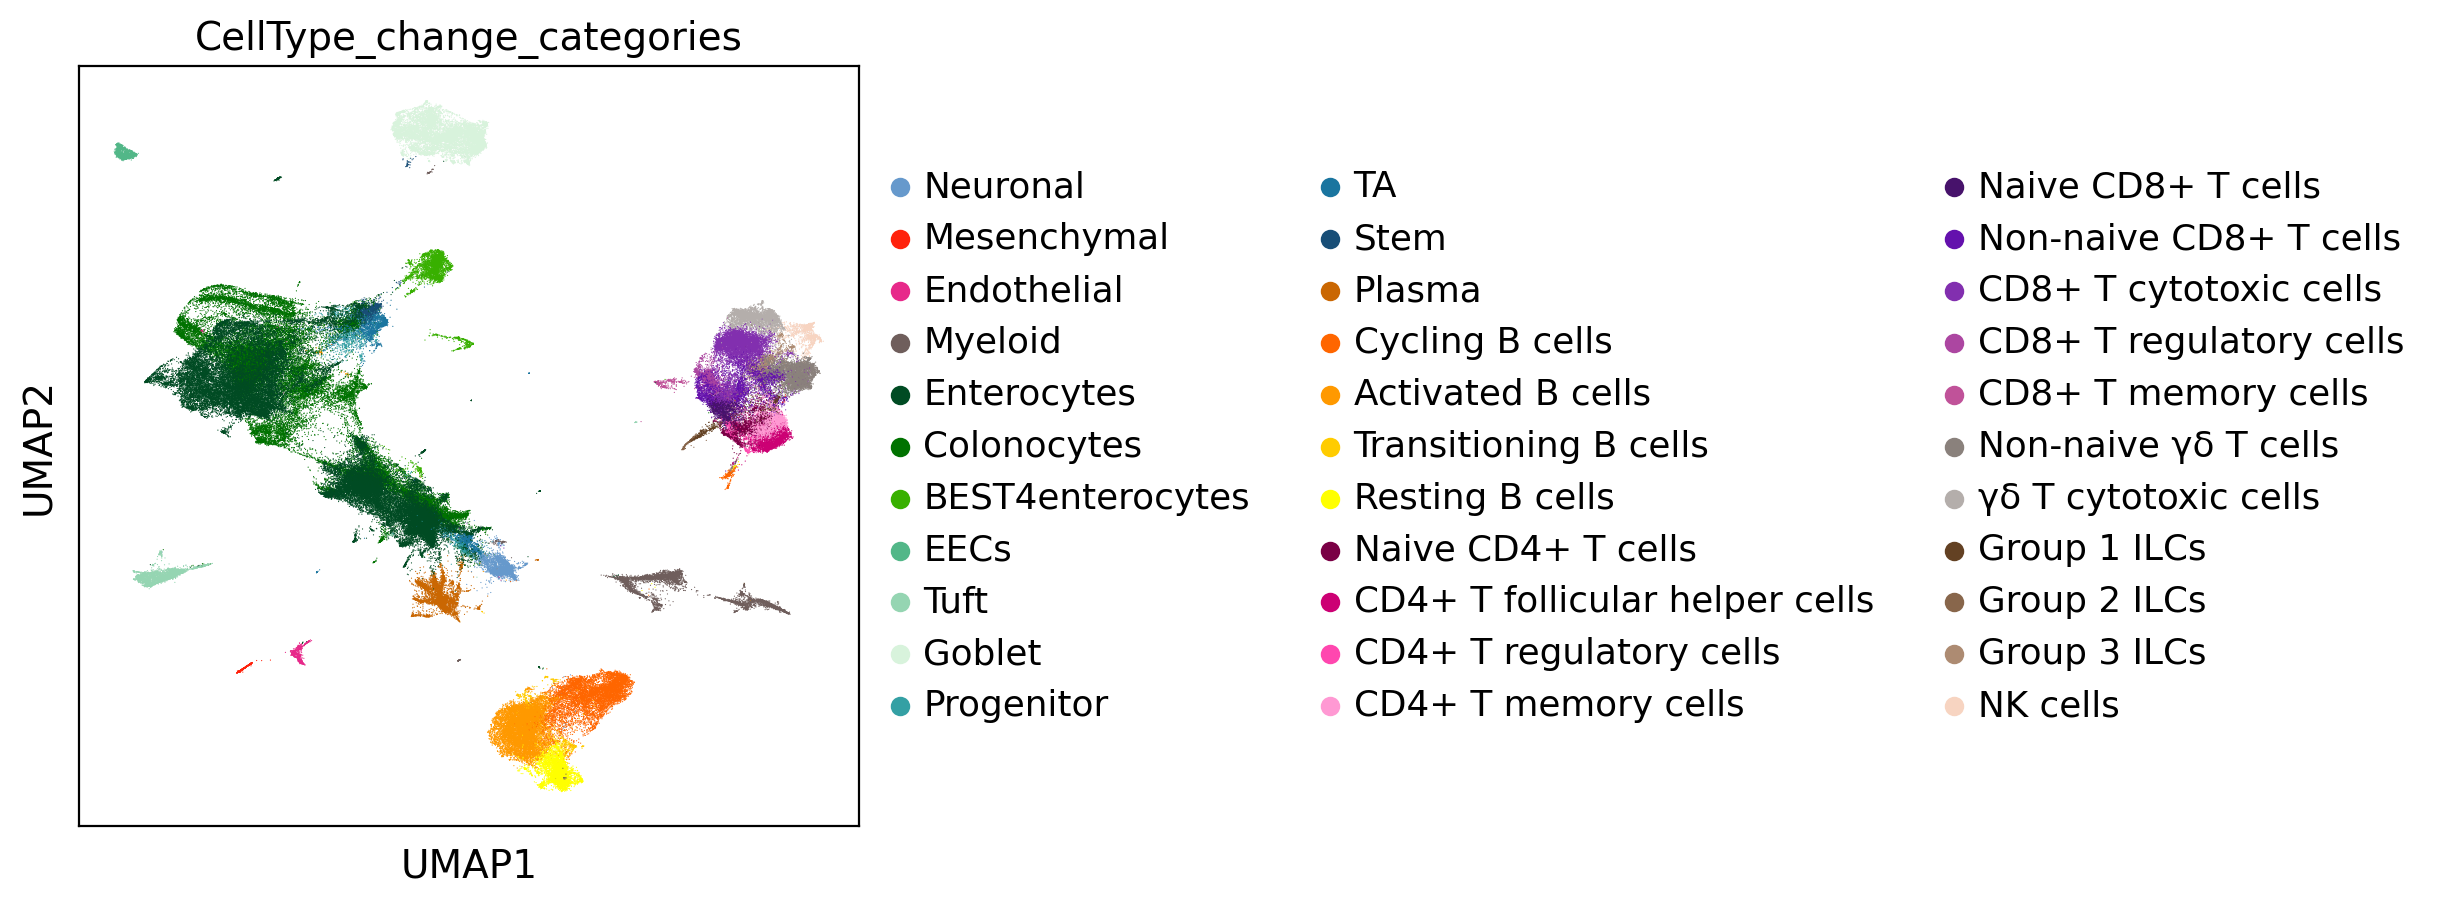

In [ ]:
sc.pl.umap(adata, color=['CellType'], palette=newcolors, save='_IntegrativeMap.pdf')

In [115]:
adata.write('Integrative_Map_CellType.h5ad')

# **CellType: Epithelial**

In [76]:
os.chdir('/disk213/xieqq/JINHUA138.sc')

In [120]:
adata=sc.read_h5ad('adata_CellLineage_rank_genes_groups.h5ad')

In [123]:
Epithelial=adata[adata.obs['CellLineage'].isin(['Epithelial'])]

In [ ]:
sc.tl.leiden(Epithelial)

In [ ]:
sc.tl.leiden(Epithelial,resolution=0.5,key_added='cluster_0.5')

## **marker gene**

In [ ]:
##Enterocytes
GENE = ['ANPEP','FABP2','CLCA4','SLC5A1','SI','ACE2']
sc.pl.umap(Epithelial,color=GENE)
sc.pl.violin(Epithelial, keys=GENE, groupby='cluster_0.5')
##Colonocytes
GENE = ['CA2','SLC26A2']
sc.pl.umap(Epithelial,color=GENE)
sc.pl.violin(Epithelial, keys=GENE, groupby='cluster_0.5')

In [ ]:
##BEST4 enterocytes
GENE = ['BEST4','GUCA2B','CFTR','NOTCH2']
sc.pl.umap(Epithelial,color=GENE)
sc.pl.violin(Epithelial, keys=GENE, groupby='cluster_0.5')

In [ ]:
##Goblet cells
GENE = ['CLCA1','SPDEF','TFF3','REG4','SPINK4','CXCL8']
sc.pl.umap(Epithelial,color=GENE)
sc.pl.violin(Epithelial, keys=GENE, groupby='cluster_0.5')

In [ ]:
##Tuft
GENE = ['POU2F3','IRAG2']
sc.pl.umap(Epithelial,color=GENE)
sc.pl.violin(Epithelial, keys=GENE, groupby='cluster_0.5')

In [ ]:
##EEC: Endometrial Epithelial Cells
GENE = ['CHGA','CHGB','NEUROD1']
sc.pl.umap(Epithelial,color=GENE)
sc.pl.violin(Epithelial, keys=GENE, groupby='cluster_0.5')

In [ ]:
##Stem cells
sc.pl.umap(Epithelial,color=['LGR5','SMOC2','RGMB','AXIN2'])
##TA: transit-amplifying
sc.pl.umap(Epithelial,color=['TOP2A','PCNA'])
##Progenitor cell
sc.pl.umap(Epithelial,color=['CDK6','AKAP7','RBPJ'])

##intestinal revival stem cells
#sc.pl.umap(Epithelial,color=['CLU'])
##proximal progenitors
#sc.pl.umap(Epithelial,color=['FGG','BEX5'])
##distal progenitors
#sc.pl.umap(Epithelial,color=['CKB','AKAP7'])
##pancreatic progenitors
#sc.pl.umap(Epithelial,color=['RBPJ','CPA1'])

In [ ]:
##Microfold
##sc.pl.umap(Epithelial,color=['SPIB','CCL20','GP2'])

##Paneth cells
# sc.pl.umap(Epithelial,color=['CA4','PIGR'])

In [ ]:
def function(a):
    if a in ['0','2','4','13','14','15','16','20']:
        return "Enterocytes"
    elif a in ['6','7','10','18']:
        return "Colonocytes"
    elif a in ['8','12']:
        return "BEST4enterocytes"
    elif a in ['9']:
        return "Tuft"
    elif a in ['3']:
        return "Goblet"
    elif a in ['11']:
        return "EECs"
    elif a in ['17','19']:
        return "TA"
    elif a in ['1']:
        return "mass1"
    elif a in ['5']:
        return "mass2"
df = Epithelial.obs
df["CellType"] = df.apply(lambda x: function(x['cluster_0.5']),axis=1) 

In [138]:
mass1 = Epithelial[Epithelial.obs['CellType'].isin(['mass1'])]

In [ ]:
sc.tl.leiden(mass1)
sc.tl.leiden(mass1,resolution=0.5,key_added='mass_cluster_0.5')
sc.pl.umap(mass1,color=['leiden','mass_cluster_0.5'],legend_loc='on data',legend_fontsize='xx-small')
sc.pl.umap(mass1,color=['leiden','mass_cluster_0.5'])

In [ ]:
##Enterocytes
GENE = ['ANPEP','FABP2','CLCA4','SLC5A1','SI','ACE2']
sc.pl.umap(mass1,color=GENE)
sc.pl.violin(mass1, keys=GENE, groupby='leiden')
##Colonocytes
GENE = ['CA2','SLC26A2']
sc.pl.umap(mass1,color=GENE)
sc.pl.violin(mass1, keys=GENE, groupby='leiden')

In [ ]:
#Stem cells
GENE = ['LGR5','SMOC2','RGMB','AXIN2']
sc.pl.umap(mass1,color=GENE)
sc.pl.violin(mass1, keys=GENE, groupby='leiden')
##TA: transit-amplifying
GENE = ['TOP2A','PCNA']
sc.pl.umap(mass1,color=GENE)
sc.pl.violin(mass1, keys=GENE, groupby='leiden')
#Progenitor cell
GENE = ['CDK6','AKAP7','RBPJ']
sc.pl.umap(mass1,color=GENE)
sc.pl.violin(mass1, keys=GENE, groupby='leiden')

In [ ]:
def function(a):
    if a in ['4']:
        return "TA"
    elif a in ['0','1','2','5','6','8','9','11','12','13','14','15']:
        return "Enterocytes"
    elif a in ['3','7','10']:
        return "Colonocytes"
df = mass1.obs
df["CellType"] = df.apply(lambda x: function(x['leiden']),axis=1) 

In [231]:
Epithelial.obs.loc[mass1.obs_names,'CellType'] = mass1.obs['CellType'].astype('object')

In [232]:
Epithelial.obs['CellType'] = Epithelial.obs['CellType'].cat.remove_unused_categories()

In [ ]:
TA = Epithelial[Epithelial.obs['CellType'].isin(['TA'])]
sc.tl.leiden(TA)
sc.tl.leiden(TA,resolution=0.5,key_added='mass_cluster_0.5')
sc.pl.umap(TA,color=['leiden','mass_cluster_0.5'],legend_loc='on data',legend_fontsize='xx-small')
sc.pl.umap(TA,color=['leiden','mass_cluster_0.5'])

In [ ]:
##Enterocytes
GENE = ['ANPEP','FABP2','CLCA4','SLC5A1','SI','ACE2']
sc.pl.umap(TA,color=GENE)
sc.pl.violin(TA, keys=GENE, groupby='mass_cluster_0.5')
##Colonocytes
GENE = ['CA2','SLC26A2']
sc.pl.umap(TA,color=GENE)
sc.pl.violin(TA, keys=GENE, groupby='mass_cluster_0.5')

In [ ]:
#Stem cells
# GENE = ['LGR5','SMOC2','RGMB','AXIN2']
# sc.pl.umap(TA,color=GENE)
# sc.pl.violin(TA, keys=GENE, groupby='mass_cluster_0.5')
##TA: transit-amplifying
GENE = ['TOP2A','PCNA']
sc.pl.umap(TA,color=GENE)
sc.pl.violin(TA, keys=GENE, groupby='mass_cluster_0.5')
#Progenitor cell
GENE = ['CDK6','AKAP7','RBPJ']
sc.pl.umap(TA,color=GENE)
sc.pl.violin(TA, keys=GENE, groupby='mass_cluster_0.5')

In [ ]:
def function(a):
    if a in ['0','2','4','6']:
        return "TA"
    elif a in ['1','5','7']:
        return "Progenitor"
    elif a in ['3']:
        return "Enterocytes"
df = TA.obs
df["CellType"] = df.apply(lambda x: function(x['mass_cluster_0.5']),axis=1) 

In [ ]:
Epithelial.obs['CellType'].cat.categories.tolist()

In [ ]:
TA.obs['CellType'].cat.categories.tolist()

In [234]:
Epithelial.obs['CellType'] = Epithelial.obs['CellType'].cat.add_categories('Progenitor')

In [235]:
Epithelial.obs.loc[TA.obs_names,'CellType'] = TA.obs['CellType'].astype('object')

In [155]:
mass2 = Epithelial[Epithelial.obs['CellType'].isin(['mass2'])]

In [ ]:
sc.tl.leiden(mass2)
sc.tl.leiden(mass2,resolution=0.4,key_added='mass_cluster_0.4')
sc.pl.umap(mass2,color=['leiden','mass_cluster_0.4'],legend_loc='on data',legend_fontsize='xx-small')
sc.pl.umap(mass2,color=['leiden','mass_cluster_0.4'])

In [ ]:
##Enterocytes
GENE = ['ANPEP','FABP2','CLCA4','SLC5A1','SI','ACE2']
sc.pl.umap(mass2,color=GENE)
sc.pl.violin(mass2, keys=GENE, groupby='leiden')
##Colonocytes
GENE = ['CA2','SLC26A2']
sc.pl.umap(mass2,color=GENE)
sc.pl.violin(mass2, keys=GENE, groupby='leiden')

In [ ]:
#Stem cells
GENE = ['LGR5','SMOC2','RGMB','AXIN2']
sc.pl.umap(mass2,color=GENE)
sc.pl.violin(mass2, keys=GENE, groupby='leiden')
##TA: transit-amplifying
GENE = ['TOP2A','PCNA']
sc.pl.umap(mass2,color=GENE)
sc.pl.violin(mass2, keys=GENE, groupby='leiden')
#Progenitor cell
GENE = ['CDK6','AKAP7','RBPJ']
sc.pl.umap(mass2,color=GENE)
sc.pl.violin(mass2, keys=GENE, groupby='leiden')

In [ ]:
def function(a):
    if a in ['1','11']:
        return "Stem"
    elif a in ['6','10','12']:
        return "Progenitor"
    elif a in ['2','4','8','9']:
        return "TA"
    elif a in ['3','5','7','13','14']:
        return "Enterocytes"
    elif a in ['0']:
        return "Colonocytes"
df = mass2.obs
df["CellType"] = df.apply(lambda x: function(x['leiden']),axis=1) 

In [238]:
Epithelial.obs['CellType'] = Epithelial.obs['CellType'].cat.add_categories('Stem')

In [239]:
Epithelial.obs.loc[mass2.obs_names,'CellType'] = mass2.obs['CellType'].astype('object')

In [240]:
Epithelial.obs['CellType'] = Epithelial.obs['CellType'].cat.remove_unused_categories()

In [21]:
Epithelial_newcolors = ['#004B23','#007200','#38B000','#52B788','#95D5B2','#D8F3DC','#34A0A4','#1A759F','#184E77']

In [ ]:
sc.pl.umap(Epithelial, color=['CellType'], palette=Epithelial_newcolors, save='_Epithelial.pdf')

In [253]:
Epithelial.write_h5ad('Epithelial_CellType.h5ad')

## *Cell ratio*

In [ ]:
times = ['small-0', 'small-60', 'small-90', 'small-180', 'small-240',
         'large-0', 'large-60', 'large-90', 'large-180', 'large-240']
categories = Epithelial.obs['Epithelial_change_categories'].cat.categories.tolist()
histogram_dict = {}
for time in times:
    histogram_data = Epithelial[Epithelial.obs['INTESTINAL-TIME'].isin([time])]
    histogram_count = histogram_data.obs.groupby(['Epithelial_change_categories'])['INTESTINAL-TIME'].count()
    histogram_count = histogram_count.reindex(categories, fill_value=0)
    histogram_dict[time] = histogram_count

In [ ]:
list1 = []
for time in times:
    list1.append(histogram_dict[time])
list1 = np.array(list1)
print(list1)

In [ ]:
# Relative proportions of cell lineages at each developmental stage
xlabels = times
ylabels = ['0','20','40','60','80','100']
cell1 = np.array(list1[:,0])
cell2 = np.array(list1[:,1])
cell3 = np.array(list1[:,2])
cell4 = np.array(list1[:,3])
cell5 = np.array(list1[:,4])
cell6 = np.array(list1[:,5])
cell7 = np.array(list1[:,6])
cell8 = np.array(list1[:,7])
cell9 = np.array(list1[:,8])
data = [cell1, cell2, cell3, cell4, cell5, cell6, cell7, cell8, cell9]
legend = categories

x = range(len(xlabels))
width = 0.6
bottom_y = np.zeros(len(xlabels))
data = np.array(data)
sums = np.sum(data, axis=0)

plt.figure(figsize=(15, 4))
for i in range(len(data)):
    colorbar = Epithelial_newcolors[i]
    y = data[i] / sums
    plt.bar(x, y, width, bottom=bottom_y, color=colorbar)
    bottom_y = y + bottom_y
ax=plt.gca()
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.grid(False)
plt.legend(frameon=False,bbox_to_anchor=(1.01,1), fancybox=True, ncol=1, labels=legend)
plt.ylabel("Proportion of total (%)")
plt.xticks(x, xlabels, rotation=90)
plt.yticks([0,0.2,0.4,0.6,0.8,1], ylabels)
plt.savefig('./figures/histogram_Epithelial_all.pdf', bbox_inches='tight')
plt.show()

## *top/marker gene*

In [283]:
sc.tl.rank_genes_groups(Epithelial, groupby='Epithelial_change_categories', method='wilcoxon', n_genes=20, key_added='rank_genes_groups_Epithelial')

In [ ]:
result = Epithelial.uns['rank_genes_groups_Epithelial']
groups = result['names'].dtype.names
marker=pd.DataFrame(
    {group + '_' + key[:1]: result[key][group]
    for group in groups for key in ['names', 'pvals','logfoldchanges','scores']})
marker.to_csv("/disk213/xieqq/JINHUA138.sc/Top_Marker_Gene/rank_genes_groups_Epithelial.csv")

In [285]:
Epithelial.write('Epithelial_CellType_rank_genes_groups.h5ad')

In [ ]:
sc.pl.rank_genes_groups_dotplot(Epithelial, n_genes=5, key='rank_genes_groups_Epithelial', standard_scale='var', cmap='Greens', save='Epithelial_TopGene.pdf')

In [10]:
marker_genes_dict = {
    'Enterocytes':['ANPEP','FABP2','CLCA4','SLC5A1','SI','ACE2'],
    'Colonocytes': ['CA2','SLC26A2'],
    'BEST4enterocytes': ['BEST4','GUCA2B','CFTR','NOTCH2'],
    'EECs':['CHGA','CHGB','NEUROD1'],
    'Goblet':['CLCA1','SPDEF','TFF3','REG4','SPINK4','CXCL8'],
    'TA':['TOP2A','PCNA'],
    'Tuft':['POU2F3','IRAG2'],
    'Stem':['LGR5','SMOC2','RGMB','AXIN2'],
    'Progenitor':['CDK6','AKAP7','RBPJ']
}

In [ ]:
sc.pl.rank_genes_groups_dotplot(Epithelial, var_names=marker_genes_dict, key='rank_genes_groups_Epithelial', standard_scale='var', cmap='Greens', save='Epithelial_MarkerGene.pdf')

## Subcellular correlation

In [ ]:
colors = ["#000080","#FFFFFF","#CD2626"]
cmap_custom = mcolors.LinearSegmentedColormap.from_list("custom_colormap", colors)

sc.tl.dendrogram(Epithelial, groupby='Epithelial_change_categories', cor_method='spearman') 
sc.pl.correlation_matrix(Epithelial, groupby='Epithelial_change_categories', dendrogram=True, cmap=cmap_custom, save='_correlation_spearman.pdf')
sc.pl.correlation_matrix(Epithelial, groupby='Epithelial_change_categories', dendrogram=True, cmap=cmap_custom, show=False, show_correlation_numbers=True, save='_correlation_spearman_shownum.pdf') 

correlation_matrix = Epithelial.uns['dendrogram_Epithelial_change_categories']['correlation_matrix']
categories_ordered = Epithelial.obs['Epithelial_change_categories'].cat.categories.tolist()

df_correlation = pd.DataFrame(correlation_matrix, index=categories_ordered, columns=categories_ordered)
df_correlation.to_csv('/disk213/xieqq/JINHUA138.sc/Enterocytes_Colonocytes/correlation_spearman.csv', index=True, header=True)

In [307]:
Enterocytes = Epithelial[Epithelial.obs['CellType'].isin(['Enterocytes'])]
Colonocytes = Epithelial[Epithelial.obs['CellType'].isin(['Colonocytes'])]
Enterocytes_Colonocytes = Epithelial[Epithelial.obs['CellType'].isin(['Enterocytes','Colonocytes'])]

In [308]:
Enterocytes_Colonocytes.write('/disk213/xieqq/JINHUA138.sc/Enterocytes_Colonocytes/Enterocytes_Colonocytes.h5ad')

In [2]:
os.chdir('/disk213/xieqq/JINHUA138.sc/Enterocytes_Colonocytes')

In [3]:
Enterocytes_Colonocytes=sc.read_h5ad('Enterocytes_Colonocytes.h5ad')
Enterocytes_Colonocytes.uns['log1p']["base"] = None

In [ ]:
sc.tl.rank_genes_groups(Enterocytes_Colonocytes, groupby='CellType', method='wilcoxon', corr_method='benjamini-hochberg', key_added='DEG')

result = Enterocytes_Colonocytes.uns['DEG']
groups = result['names'].dtype.names
marker=pd.DataFrame(
    {group + '_' + key: result[key][group]
     for group in groups for key in ['names', 'pvals', 'pvals_adj', 'logfoldchanges']})
marker.to_csv("DEG_CellType.csv")

In [4]:
Enterocytes = Enterocytes_Colonocytes[Enterocytes_Colonocytes.obs['CellType'].isin(['Enterocytes'])]
Colonocytes = Enterocytes_Colonocytes[Enterocytes_Colonocytes.obs['CellType'].isin(['Colonocytes'])]

In [ ]:
sc.tl.rank_genes_groups(Enterocytes, groupby='TIME', method='wilcoxon', corr_method='benjamini-hochberg', key_added='DEG')

result = Enterocytes.uns['DEG']
groups = result['names'].dtype.names
marker=pd.DataFrame(
    {group + '_' + key[:1]: result[key][group]
    for group in groups for key in ['names', 'pvals_adj', 'logfoldchanges']})
marker.to_csv("DEG_Enterocytes_Time.csv")

In [ ]:
sc.tl.rank_genes_groups(Colonocytes, groupby='TIME', method='wilcoxon', corr_method='benjamini-hochberg', key_added='DEG')

result = Colonocytes.uns['DEG']
groups = result['names'].dtype.names
marker=pd.DataFrame(
    {group + '_' + key[:1]: result[key][group]
    for group in groups for key in ['names', 'pvals', 'pvals_adj', 'logfoldchanges']})
marker.to_csv("DEG_Colonocytes_Time.csv")

In [8]:
os.chdir('/disk213/xieqq/JINHUA138.sc/Enterocytes_Colonocytes/Compare')

In [5]:
adata=Enterocytes_Colonocytes
adata.obs['CellType-TIME'] = adata.obs[['Epithelial_change_categories','TIME']].apply(lambda x: '-'.join(x), axis=1)
adata=adata[adata.obs['CellType-TIME'].groupby(adata.obs['CellType-TIME']).transform(len) >= 2, :]

In [6]:
CellTypes = adata.obs['CellType'].cat.categories.tolist()

In [9]:
groups_list =    ['-0', '-0', '-0',  '-0',  '-60','-60', '-60', '-90', '-90', '-180']
reference_list = ['-60','-90','-180','-240','-90','-180','-240','-180','-240','-240']

In [ ]:
for i in range(len(groups_list)):
    for celltype in CellTypes[:]:
        groups=celltype+groups_list[i]
        reference=celltype+reference_list[i]
        filename='DEG_'+groups+'_'+reference
        
        groupby_values = adata.obs['CellType-TIME'].values
        groups_in_groupby = pd.Series(groups).isin(groupby_values)
        reference_in_groupby = pd.Series(reference).isin(groupby_values)
        if groups_in_groupby.any() and reference_in_groupby.any():
            sc.tl.rank_genes_groups(adata, groupby='CellType-TIME', groups=[groups], reference=reference, method='wilcoxon', corr_method='benjamini-hochberg', key_added=filename)
            result = adata.uns[filename]
            groups = result['names'].dtype.names
            marker=pd.DataFrame(
                {group + '_' + key: result[key][group]
                 for group in groups for key in ['names', 'pvals', 'pvals_adj', 'logfoldchanges']})
            marker.columns = ['gene', 'PValue', 'Padj', 'logFC']
            data=marker
            data.loc[data.PValue==0,'PValue']=min(filter(lambda x: x>0, data['PValue']))
            data['LogPValue']=-data.PValue.apply(math.log10)
            data.loc[data.Padj==0,'Padj']=min(filter(lambda x: x>0, data['Padj']))
            data['LogPadj']=-data.Padj.apply(math.log10)
            data.loc[(data.logFC>2.5)&(data.Padj<0.05),'type']='up'
            data.loc[(data.logFC<-2.5)&(data.Padj<0.05),'type']='down'
            data.loc[(abs(data.logFC)<=2.5)|(data.Padj>=0.05),'type']='none'
            data.to_csv(filename+'.csv')
        else:
            pass

# **Public Data**

In [8]:
os.chdir('/disk213/xieqq/JINHUA138.sc/Public_data')

## **Human**

### **Data**

In [ ]:
adata=sc.read_h5ad('/disk213/xieqq/JINHUA138.sc/Public_data/data/Full_obj_log_counts_soupx_v2.h5ad')   #PRJNA666217

In [ ]:
sc.pl.violin(adata,["n_genes_by_counts", "pct_counts_mt"],jitter=False,stripplot=False, multi_panel=True, save='_Human_beforeQC.pdf')

In [ ]:
adata = adata[adata.obs.n_genes_by_counts < 7500, :]
adata = adata[adata.obs.n_genes_by_counts > 200, :]
adata = adata[adata.obs.pct_counts_mt < 50, :]
sc.pl.violin(adata,["n_genes_by_counts", "pct_counts_mt"],jitter=False,stripplot=False, multi_panel=True, save='_Human_afterQC.pdf')

In [ ]:
def function(a):
    if a in ['DUO','JEJ','FMIL','FPIL','FTIL','ILE','ILE1','ILE2','TIL']:
        return 'small' 
    elif a in ['CAE','ACL','DCL','TCL','SCL']:
        return "large" 
adata.obs["INTESTINAL"]=adata.obs.apply(lambda x: function(x['Region code']),axis=1)
adata.obs["INTESTINAL"]=adata.obs["INTESTINAL"].astype('category')

In [14]:
adata.obs["TIME"]=adata.obs["Age"]
adata.obs["TIME"].replace({"4": "4y", "6": "6y", "9": "9y", "10": "10y", "11": "11y", "12": "12y", "13": "13y", "14": "14y",
                           "20-25": "20-25y", "25-30": "25-30y", "45-50": "45-50y", "60-65": "60-65y", "65-70": "65-70y", "70-75": "70-75y"}, inplace=True)
adata.obs["TIME"]=adata.obs["TIME"].astype('category')

In [ ]:
adata = adata[adata.obs['INTESTINAL'].isin(['small','large'])]
adata = adata[adata.obs['Diagnosis'].isin(['Healthy adult','fetal','Pediatric healthy'])]

In [466]:
# adata.obs["CellLineage"]=adata.obs["category"]
# adata.obs["CellLineage"]=adata.obs["CellLineage"].astype('category')
# adata.obs["CellType"]=adata.obs["Integrated_05"]
# adata.obs["CellType"]=adata.obs["CellType"].astype('category')

In [ ]:
# adata.obs['Sample name'].cat.categories.tolist()
# adata.obs['Diagnosis'].cat.categories.tolist()
# adata.obs['Age'].cat.categories.tolist()
# adata.obs['sample name'].cat.categories.tolist()
# adata.obs['Region code'].cat.categories.tolist()
# adata.obs['Fraction'].cat.categories.tolist()
# adata.obs['Gender'].cat.categories.tolist()
# adata.obs['Region'].cat.categories.tolist()
# adata.obs['batch'].cat.categories.tolist()
# adata.obs['category'].cat.categories.tolist()
# adata.obs['Age_group'].cat.categories.tolist()
# adata.obs['Integrated_05'].cat.categories.tolist()

### **PCA+harmony+reduction+cluster**

In [ ]:
sc.tl.pca(adata, svd_solver='arpack')
sc.pl.pca_variance_ratio(adata, log=True, n_pcs=50)

In [ ]:
sc.external.pp.harmony_integrate(adata, 'batch', basis='X_pca', adjusted_basis='X_pca_harmony')

In [ ]:
sc.pp.neighbors(adata, use_rep="X_pca_harmony")

In [23]:
sc.tl.umap(adata, min_dist=0.1)

In [24]:
sc.tl.tsne(adata,use_rep="X_pca_harmony")

### **annotation**

In [ ]:
sc.tl.leiden(adata)
sc.pl.umap(adata,color=['leiden'],legend_loc='on data')

In [ ]:
GENE = ['EPCAM','KRT8','ELF3','SLC44A4']
sc.pl.umap(adata,color=GENE)  # epithelial cell genes
with rc_context({'figure.figsize':(15,5)}): 
    sc.pl.violin(adata, keys=GENE, groupby='leiden')

In [ ]:
def function(a):
    if a in ['0','1','2','5','11','16','20','24','28','29','32','36','39','40','41']:
        return 'Epithelial' 
adata.obs["CellLineage"]=adata.obs.apply(lambda x: function(x['leiden']),axis=1) 

In [28]:
adata.obs["CellType"]=adata.obs["CellLineage"]

In [29]:
Epithelial=adata[adata.obs['CellLineage'].isin(['Epithelial'])]

In [ ]:
sc.tl.leiden(Epithelial)
sc.pl.umap(Epithelial,color=['leiden'],legend_loc='on data')

In [ ]:
##Enterocytes
GENE = ['ANPEP','FABP2','CLCA4','SLC5A1','SI','ACE2']
sc.pl.umap(Epithelial,color=GENE)
with rc_context({'figure.figsize':(15,5)}): 
    sc.pl.violin(Epithelial, keys=GENE, groupby='leiden')
##Colonocytes
GENE = ['CA2','SLC26A2']
sc.pl.umap(Epithelial,color=GENE)
with rc_context({'figure.figsize':(15,5)}): 
    sc.pl.violin(Epithelial, keys=GENE, groupby='leiden')

In [ ]:
def function(a):
    if a in ['0','2','4','13','14','15','16','20']:
        return "Enterocytes"
    elif a in ['6','7','10','18']:
        return "Colonocytes"
df = Epithelial.obs
df["CellType"] = df.apply(lambda x: function(x['leiden']),axis=1) 

In [40]:
adata.obs['CellType'] = adata.obs['CellType'].cat.add_categories('Enterocytes')
adata.obs['CellType'] = adata.obs['CellType'].cat.add_categories('Colonocytes')
adata.obs.loc[Epithelial.obs_names,'CellType'] = Epithelial.obs['CellType'].astype('object')
adata.obs['CellType'] = adata.obs['CellType'].cat.remove_unused_categories()

In [42]:
adata.write('Human_intestine.h5ad')

## **Commercial pig**

### **Data**

In [ ]:
adata=sc.read_h5ad('/disk213/xieqq/JINHUA138.sc/Public_data/data/atlas_level2.h5ad')

In [ ]:
sc.pl.violin(adata,["n_genes_by_counts", "pct_counts_mt"],jitter=False,stripplot=False, multi_panel=True, save='_CP_beforeQC.pdf')

In [ ]:
adata = adata[adata.obs.n_genes_by_counts < 7500, :]
adata = adata[adata.obs.n_genes_by_counts > 200, :]
adata = adata[adata.obs.pct_counts_mt < 50, :]
sc.pl.violin(adata,["n_genes_by_counts", "pct_counts_mt"],jitter=False,stripplot=False, multi_panel=True, save='_CP_afterQC.pdf')

In [48]:
data = pd.read_csv('/disk213/xieqq/JINHUA138.sc/Public_data/data/GEO_metadata.csv')

In [ ]:
mapping_dict_breed = dict(zip(data['Dataset'], data['breed']))
mapping_dict_stage = dict(zip(data['Dataset'], data['stage']))

In [ ]:
adata.obs['BREED'] = adata.obs['project'].map(mapping_dict_breed)
adata.obs['TIME'] = adata.obs['project'].map(mapping_dict_stage)
adata.obs["BREED"]=adata.obs["BREED"].astype('category')
adata.obs["TIME"]=adata.obs["TIME"].astype('category')

In [ ]:
adata = adata[adata.obs['INTESTINAL'].isin(['small','large'])]
adata = adata[adata.obs['BREED'].isin(['Duroc','LY','large white','DLY','Mixed'])]
adata = adata[adata.obs['TIME'].isin(['0d','1d','3d','5d','7d','14d','21d','49d','60d','90d','160d','180d','240d'])]

### **PCA+harmony+reduction+cluster**

In [56]:
sc.tl.pca(adata, svd_solver='arpack')

In [ ]:
sc.tl.pca(adata, svd_solver='arpack')
sc.pl.pca_variance_ratio(adata, log=True, n_pcs=50)

In [ ]:
sc.external.pp.harmony_integrate(adata, 'project', basis='X_pca', adjusted_basis='X_pca_harmony')

In [ ]:
sc.pp.neighbors(adata, use_rep="X_pca_harmony")

In [62]:
sc.tl.umap(adata, min_dist=0.1)

In [63]:
sc.tl.tsne(adata,use_rep="X_pca_harmony")

In [65]:
adata.write('CP_intestine.h5ad')

### **annotation**

In [ ]:
adata=sc.read_h5ad('CP_intestine.h5ad')

In [ ]:
sc.tl.leiden(adata)
sc.pl.umap(adata,color=['leiden'],legend_loc='on data')

In [ ]:
GENE = ['EPCAM','KRT8','ELF3','SLC44A4']
sc.pl.umap(adata,color=GENE)  # epithelial cell genes
with rc_context({'figure.figsize':(15,5)}): 
    sc.pl.violin(adata, keys=GENE, groupby='leiden')

In [ ]:
def function(a):
    if a in ['4','7','9','14','15','19','20','21','22','24','25','26','29','30','33','34']:
        return 'Epithelial' 
adata.obs["CellLineage"]=adata.obs.apply(lambda x: function(x['leiden']),axis=1) 

In [77]:
adata.obs["CellType"]=adata.obs["CellLineage"]

In [79]:
Epithelial=adata[adata.obs['CellLineage'].isin(['Epithelial'])]

In [ ]:
sc.tl.leiden(Epithelial)
sc.pl.umap(Epithelial,color=['leiden'],legend_loc='on data',legend_fontsize='xx-small')

In [ ]:
##Enterocytes
GENE = ['ANPEP','FABP2','CLCA4','SLC5A1','SI','ACE2']
sc.pl.umap(Epithelial,color=GENE)
with rc_context({'figure.figsize':(15,5)}): 
    sc.pl.violin(Epithelial, keys=GENE, groupby='leiden')
##Colonocytes
GENE = ['CA2','SLC26A2']
sc.pl.umap(Epithelial,color=GENE)
with rc_context({'figure.figsize':(15,5)}): 
    sc.pl.violin(Epithelial, keys=GENE, groupby='leiden')

In [ ]:
def function(a):
    if a in ['2','9','11','13','17','18','24','26','27','28','33','34','38']:
        return "Enterocytes"
    elif a in ['3','8','14','15','31','35']:
        return "Colonocytes"
df = Epithelial.obs
df["CellType"] = df.apply(lambda x: function(x['leiden']),axis=1) 

In [87]:
adata.obs['CellType'] = adata.obs['CellType'].cat.add_categories('Enterocytes')
adata.obs['CellType'] = adata.obs['CellType'].cat.add_categories('Colonocytes')
adata.obs.loc[Epithelial.obs_names,'CellType'] = Epithelial.obs['CellType'].astype('object')
adata.obs['CellType'] = adata.obs['CellType'].cat.remove_unused_categories()

In [90]:
adata.write('CP_intestine.h5ad')

## **Merge (shared genes)**

In [5]:
os.chdir('/disk213/xieqq/JINHUA138.sc/Public_data')

In [ ]:
adata_Jinhua=sc.read_h5ad('/disk213/xieqq/JINHUA138.sc/Epithelial_CellType.h5ad')
var_names_df = pd.DataFrame(adata_Jinhua.var_names, columns=['gene_Jinhua'])
var_names_df.to_csv('gene_Jinhua.csv', index=False)

adata_CP=sc.read_h5ad('CP_intestine.h5ad')
var_names_df = pd.DataFrame(adata_CP.var_names, columns=['gene_CP'])
var_names_df.to_csv('gene_CP.csv', index=False)

adata_Human=sc.read_h5ad('Human_intestine.h5ad')
var_names_df = pd.DataFrame(adata_Human.var_names, columns=['gene_Human'])
var_names_df.to_csv('gene_Human.csv', index=False)

gene_intersect = pd.read_csv('gene_intersect.csv', header=1, names=['intersect'])

In [ ]:
replace_df = pd.read_csv('gene_Jinhua.csv', header=1, names=['gene_Jinhua', 'To'])

for index, row in replace_df.iterrows():
    gene = str(row['gene_Jinhua'])
    replace_gene = str(row['To'])
    pattern = r'\b{}\b'.format(re.escape(gene)) 
    adata_Jinhua.var_names = adata_Jinhua.var_names.str.replace(pattern, replace_gene, regex=True)

In [226]:
adata_Jinhua=adata_Jinhua[:, ~adata_Jinhua.var_names.isin(['undefined'])]
adata_Jinhua.var_names_make_unique()

In [186]:
replace_df = pd.read_csv('gene_CP.csv', header=1, names=['gene_CP', 'To'])

for index, row in replace_df.iterrows():
    gene = str(row['gene_CP'])
    replace_gene = str(row['To'])
    pattern = r'\b{}\b'.format(re.escape(gene))
    adata_CP.var_names = adata_CP.var_names.str.replace(pattern, replace_gene, regex=True)

In [192]:
adata_CP=adata_CP[:, ~adata_CP.var_names.isin(['undefined'])]
adata_CP.var_names_make_unique()

In [188]:
replace_df = pd.read_csv('gene_Human.csv', header=1, names=['gene_Human', 'To'])

for index, row in replace_df.iterrows():
    gene = str(row['gene_Human'])
    replace_gene = str(row['To'])
    pattern = r'\b{}\b'.format(re.escape(gene))
    adata_Human.var_names = adata_Human.var_names.str.replace(pattern, replace_gene, regex=True)

In [191]:
adata_Human=adata_Human[:, ~adata_Human.var_names.isin(['undefined'])]
adata_Human.var_names_make_unique()

In [227]:
adata_Human.obs["PROJECT"]=adata_Human.obs["batch"]
adata_Human.obs["SPECIES"]="Human"
adata_Human.obs["BREED"]="Human"
adata_Human = adata_Human[adata_Human.obs['TIME'].isin(['4y','6y','9y','10y','12y','20-25y','25-30y','45-50y','60-65y','65-70y','70-75y'])]

adata_Jinhua.obs["PROJECT"]=adata_Jinhua.obs["BATCH"]
adata_Jinhua.obs["SPECIES"]="Pig"
adata_Jinhua.obs["BREED"]="Jinhua"
# adata_Jinhua.obs['TIME'] = adata_Jinhua.obs['TIME'].astype(str) + 'd'
# adata_Jinhua.obs["TIME"]=adata_Jinhua.obs["TIME"].astype('category')

adata_CP.obs["PROJECT"]=adata_CP.obs["project"]
adata_CP.obs["SPECIES"]="Pig"
#adata_CP.obs["BREED"]=adata_CP.obs["BREED"]

In [ ]:
adata = sc.concat([adata_Jinhua, adata_CP, adata_Human], label='CONCAT')
adata = adata[adata.obs['CellType'].isin(['Enterocytes', 'Colonocytes'])]

In [231]:
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)  
sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5)

In [232]:
sc.tl.pca(adata, svd_solver='arpack')
sc.external.pp.harmony_integrate(adata, 'PROJECT', basis='X_pca', adjusted_basis='X_pca_harmony')
sc.pp.neighbors(adata, use_rep="X_pca_harmony")
sc.tl.umap(adata, min_dist=0.1)
sc.tl.tsne(adata,use_rep="X_pca_harmony")

In [234]:
adata.write('Concat_intestine.h5ad')

In [ ]:
print(adata.obs['CellType'].cat.categories.tolist())
print(adata.obs['TIME'].cat.categories.tolist())
print(adata.obs['BREED'].cat.categories.tolist())
print(adata.obs['SPECIES'].cat.categories.tolist())
print(adata.obs['PROJECT'].cat.categories.tolist())

In [ ]:
sc.pl.umap(adata, color=['PROJECT'], save='_PROJECT.pdf')
# sc.pl.tsne(adata, color=['PROJECT'], save='_PROJECT.pdf')

In [243]:
adata.obs['SOURCE']=adata.obs['PROJECT']
our_study=['ce0','ce60','ce90','ce180','ce240','co0','co60','co90','co180','co240','du0','du60','du90','du180','du240','il0','il60','il90','il180','il240','je0','je60','je90','je180','je240','DUR_DU','DUR_JE','DUR_IL','DUR_CE','DUR_CO','EB5_DU','EB5_JE','EB5_IL','EB5_CE','EB5_CO']
pro_PRJNA681248=['PRJNA681248_ileum0','PRJNA681248_ileum1','PRJNA681248_ileum3','PRJNA681248_ileum7','PRJNA681248_ileum14','PRJNA681248_ileum21']
pro_PRJNA728441=['PRJNA728441_NSP1','PRJNA728441_NSP2','PRJNA728441_NSP3','PRJNA728441_PWP1','PRJNA728441_PWP2','PRJNA728441_PWP3']
pro_PRJNA685448=['PRJNA685448_Piglet_day0','PRJNA685448_Piglet_day7','PRJNA685448_Piglet_day14','PRJNA685448_Piglet_day21',]
pro_PRJNA859792=['PRJNA859792_DUOD1','PRJNA859792_DUOD2','PRJNA859792_DUOD3','PRJNA859792_DUOD4','PRJNA859792_JEJ1','PRJNA859792_JEJ2','PRJNA859792_JEJ3','PRJNA859792_JEJ4','PRJNA859792_IPP1','PRJNA859792_IPP2','PRJNA859792_IPP3','PRJNA859792_IPP4','PRJNA859792_NoPP1','PRJNA859792_NoPP2','PRJNA859792_NoPP4']
pro_gutcellatlas=['4918STDY7333456','4918STDY7702680','4918STDY7844899','4918STDY7447825','4918STDY7923744','4918STDY7389431','4918STDY7274839','4918STDY7844898','4918STDY7702679','4918STDY7714149','4918STDY7714150','Human_colon_16S8000471',
                  'Human_colon_16S8000473','Human_colon_16S8000475','Human_colon_16S8000477','Human_colon_16S8000479','Human_colon_16S8000487','Human_colon_16S8000489','Human_colon_16S8000491','Human_colon_16S8000493','Human_colon_16S8000511','Human_colon_16S8000513','Human_colon_16S8000515','Human_colon_16S8001863','Human_colon_16S8001865','Human_colon_16S8001867','Human_colon_16S8001869','Human_colon_16S8001871','Human_colon_16S8001878','Human_colon_16S8001879','Human_colon_16S8001881','Human_colon_16S8001883','Human_colon_16S8001885','Human_colon_16S8001903','Human_colon_16S8001905','Human_colon_16S8001907','Human_colon_16S8002566','Human_colon_16S8002581','Human_colon_16S8002582','Human_colon_16S8002623','Human_colon_16S8002624','Human_colon_16S8002626','Human_colon_16S8002627','Human_colon_16S8002628','Human_colon_16S8002629','Human_colon_16S8002630','Human_colon_16S8117829','Human_colon_16S8117830','Human_colon_16S8117831','Human_colon_16S8123908','Human_colon_16S8123910','Human_colon_16S8123911','Human_colon_16S8123912','Human_colon_16S8123913','Human_colon_16S8123915','Human_colon_16S8123916','Human_colon_16S8123917','Human_colon_16S8123918','Human_colon_16S8123920','Human_colon_16S8159191','Human_colon_16S8159193',
                  'WTDAtest7770716','WTDAtest7770717','WTDAtest7770718','WTDAtest7770719','WTDAtest7844017','WTDAtest7844018','WTDAtest7844019','WTDAtest7844020','WTDAtest7844022','WTDAtest7844024','WTDAtest7844026','WTDAtest7844027','WTDAtest7844029']

sources=['our_study','pro_PRJNA681248','pro_PRJNA728441','pro_PRJNA685448','pro_PRJNA859792','pro_gutcellatlas']
for source in sources:
    adata.obs['SOURCE']=adata.obs['SOURCE'].cat.add_categories(source)

adata.obs.loc[adata.obs['PROJECT'].isin(our_study),'SOURCE']='our_study'
adata.obs.loc[adata.obs['PROJECT'].isin(pro_PRJNA681248),'SOURCE']='pro_PRJNA681248'
adata.obs.loc[adata.obs['PROJECT'].isin(pro_PRJNA728441),'SOURCE']='pro_PRJNA728441'
adata.obs.loc[adata.obs['PROJECT'].isin(pro_PRJNA685448),'SOURCE']='pro_PRJNA685448'
adata.obs.loc[adata.obs['PROJECT'].isin(pro_PRJNA859792),'SOURCE']='pro_PRJNA859792'
adata.obs.loc[adata.obs['PROJECT'].isin(pro_gutcellatlas),'SOURCE']='pro_gutcellatlas'#Human
adata.obs['SOURCE']=adata.obs['SOURCE'].cat.remove_unused_categories()

In [ ]:
adata.obs['SOURCE'].unique()

In [ ]:
labels = ['our_study', 'pro_PRJNA681248', 'pro_PRJNA728441', 'pro_PRJNA685448', 'pro_PRJNA859792', 'pro_gutcellatlas']
adata.obs['Source_change_categories']=pd.Categorical(adata.obs['SOURCE'],categories=labels)
Source_newcolors = ['#FFADAD','#FFD6A5','#FFD6A5','#CAFFBF','#9BF6FF','#A0C4FF']
sc.pl.umap(adata, color=['Source_change_categories'], palette=Source_newcolors, save='_Source.pdf')
# sc.pl.tsne(adata, color=['Source_change_categories'], palette=Source_newcolors, save='_Source.pdf')

In [ ]:
labels = ['Enterocytes', 'Colonocytes']
adata.obs['CellType_change_categories']=pd.Categorical(adata.obs['CellType'],categories=labels)
CellType_newcolors = ['#004B23','#52B788']
sc.pl.umap(adata, color=['CellType_change_categories'], palette=CellType_newcolors, save='_CellType.pdf')
# sc.pl.tsne(adata, color=['CellType_change_categories'], palette=CellType_newcolors, save='_CellType.pdf')

In [ ]:
labels = ['0','60','90','180','240', #JH
          '0d','1d','3d','7d','14d','21d','49d','160d',  #CP
          '4y','6y','9y','10y','12y','20-25y','25-30y','45-50y','60-65y','65-70y','70-75y']   #Human
adata.obs['Time_change_categories']=pd.Categorical(adata.obs['TIME'],categories=labels)
Time_newcolors = ['#FF595E','#FFCA3A','#8AC926','#1982C4','#6A4C93',
                  '#FAE0E4','#F9BEC7','#FF99AC','#FF7096','#FF477E','#FF0A54','#FFEA00','#FFA200',
                  '#74C69D','#40916C','#2D6A4F','#1B4332','#081C15','#48CAE4','#0096C7','#023E8A','#C77DFF','#9D4EDD','#5A189A']
sc.pl.umap(adata, color=['Time_change_categories'], palette=Time_newcolors, save='_Time.pdf')
# sc.pl.tsne(adata, color=['Time_change_categories'], palette=Time_newcolors, save='_Time.pdf')

In [ ]:
labels = ['Human','Jinhua','Duroc','LY','large white','Mixed']   #Human
adata.obs['Breed_change_categories']=pd.Categorical(adata.obs['BREED'],categories=labels)
Breed_newcolors = ['#F94144','#F3722C','#F9C74F','#90BE6D','#43AA8B','#577590']
sc.pl.umap(adata, color=['Breed_change_categories'], palette=Breed_newcolors, save='_Breed.pdf')
# sc.pl.tsne(adata, color=['Breed_change_categories'], palette=Breed_newcolors, save='_Breed.pdf')

In [ ]:
labels = ['Human','Pig']   #Human
adata.obs['Species_change_categories']=pd.Categorical(adata.obs['SPECIES'],categories=labels)
Species_newcolors = ["#B499C9","#D95B5B"]
sc.pl.umap(adata, color=['Species_change_categories'], palette=Species_newcolors, save='_Species.pdf')
# sc.pl.tsne(adata, color=['Species_change_categories'], palette=Species_newcolors, save='_Species.pdf')

In [254]:
def function(a):
    if a in ['Jinhua']:
        return 'JinhuaPig' 
    elif a in ['large white', 'LY', 'Duroc', 'Mixed']:
        return "CommercialPig"
    elif a in ['Human']:
        return "Human"
adata.obs["BREEDadd"]=adata.obs.apply(lambda x: function(x['BREED']),axis=1)
adata.obs["BREEDadd"]=adata.obs["BREEDadd"].astype('category')

In [269]:
adata.obs["TIMEadd"]=adata.obs["TIME"]
adata.obs['TIMEadd'] = adata.obs['TIMEadd'].cat.add_categories('60d')
adata.obs['TIMEadd'] = adata.obs['TIMEadd'].cat.add_categories('90d')
adata.obs['TIMEadd'] = adata.obs['TIMEadd'].cat.add_categories('180d')
adata.obs['TIMEadd'] = adata.obs['TIMEadd'].cat.add_categories('240d')

mask = adata.obs['BREED'] == 'Jinhua'
adata.obs.loc[mask, 'TIMEadd'] = adata.obs.loc[mask, 'TIMEadd'].astype(str) + 'd'
adata.obs["TIMEadd"]=adata.obs["TIMEadd"].astype('category')

adata.obs['TIMEadd'] = adata.obs['TIMEadd'].cat.remove_unused_categories()

In [277]:
adata.write('Concat_intestine.h5ad')

## Pseudobulk RNA-seq

In [ ]:
#source /disk211/public/anaconda3/bin/activate /disk211/public/anaconda3/envs/labBase
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import decoupler as dc
import scanpy as sc
import os
import math
import csv

In [ ]:
adata=sc.read_h5ad('/disk213/xieqq/JINHUA138.sc/Public_data/Concat_intestine.h5ad')

In [ ]:
adata.layers['counts']=adata.X
pdata = dc.get_pseudobulk(
    adata,
    sample_col='BREEDadd-INTESTINAL-TIME',
    groups_col=None,
    layer='counts',
    mode='sum',
    min_cells=10,
    min_counts=1000
)
pdata.layers['counts'] = pdata.X.copy()

# Normalize, scale and compute pca
sc.pp.normalize_total(pdata, target_sum=1e4)
sc.pp.log1p(pdata)
sc.pp.scale(pdata, max_value=10)
sc.tl.pca(pdata)
list = pdata.T.to_df()
list.to_csv("pseudobulk_raw_counts_scaled.csv", index=True)

In [ ]:
Glist = adata.var_names
new_data = pd.DataFrame(columns=adata.obs['SPECIES-INTESTINAL-TIMEadd'].unique())
for gene_name in Glist[:]:
    expression = adata[:, gene_name].X
    mean_expression_by_cluster = []
    list = []
    for cluster in adata.obs['SPECIES-INTESTINAL-TIMEadd'].unique():
        cells_in_cluster = adata.obs['SPECIES-INTESTINAL-TIMEadd'] == cluster
        mean_expression = expression[cells_in_cluster].mean()
        mean_expression_by_cluster = mean_expression_by_cluster + [mean_expression]
    new_data = new_data.append(pd.Series(mean_expression_by_cluster, index=new_data.columns), ignore_index=True)

new_data.index = Glist
new_data.to_csv("SPECIES_Mean_Gene_Expression.csv")

In [ ]:
Glist = adata.var_names
new_data = pd.DataFrame(columns=adata.obs['BREEDadd-INTESTINAL-TIME'].unique())
for gene_name in Glist[:]:
    expression = adata[:, gene_name].X
    mean_expression_by_cluster = []
    list = []
    for cluster in adata.obs['BREEDadd-INTESTINAL-TIME'].unique():
        cells_in_cluster = adata.obs['BREEDadd-INTESTINAL-TIME'] == cluster
        mean_expression = expression[cells_in_cluster].mean()
        mean_expression_by_cluster = mean_expression_by_cluster + [mean_expression]
    new_data = new_data.append(pd.Series(mean_expression_by_cluster, index=new_data.columns), ignore_index=True)

new_data.index = Glist
new_data.to_csv("BREED_Mean_Gene_Expression.csv")

## **cell proportion**

In [27]:
adata=sc.read_h5ad('Concat_intestine.h5ad')

In [ ]:
cell = adata.n_obs
cell_counts = adata.obs['BREEDadd-INTESTINAL-TIME'].value_counts()
cell_proportion = cell_counts/cell*100

cell_counts.to_csv('cell_counts.csv', index=True, header=True)
cell_proportion.to_csv('cell_proportion.csv', index=True, header=True)

## **DEG**

In [30]:
os.chdir('/disk213/xieqq/JINHUA138.sc/Public_data')

In [43]:
adata=sc.read_h5ad('Concat_intestine.h5ad')
adata.uns['log1p']["base"] = None

In [38]:
filename='Pig-Human'
sc.tl.rank_genes_groups(adata, groupby='SPECIES', groups=['Pig'], reference='Human', method='wilcoxon', corr_method='benjamini-hochberg', key_added=filename)
result = adata.uns[filename]
groups = result['names'].dtype.names
marker=pd.DataFrame({group + '_' + key: result[key][group] for group in groups for key in ['names', 'pvals', 'pvals_adj', 'logfoldchanges']})
marker.columns = ['gene', 'PValue', 'Padj', 'logFC']
data=marker
data.loc[data.PValue==0,'PValue']=min(filter(lambda x: x>0, data['PValue']))
data['LogPValue']=-data.PValue.apply(math.log10)
data.loc[data.Padj==0,'Padj']=min(filter(lambda x: x>0, data['Padj']))
data['LogPadj']=-data.Padj.apply(math.log10)
data.loc[(data.logFC>2.5)&(data.Padj<0.05),'type']='up'
data.loc[(data.logFC<-2.5)&(data.Padj<0.05),'type']='down'
data.loc[(abs(data.logFC)<=2.5)|(data.Padj>=0.05),'type']='none'
data.to_csv('DEG_'+filename+'.csv')

In [ ]:
adata.obs['BREEDadd']

In [48]:
filename='JH-DLY'
# filename='JH-Human'
# filename='DLY-Human'
sc.tl.rank_genes_groups(adata, groupby='BREEDadd', groups=['JinhuaPig'], reference='CommercialPig', method='wilcoxon', corr_method='benjamini-hochberg', key_added=filename)
result = adata.uns[filename]
groups = result['names'].dtype.names
marker=pd.DataFrame({group + '_' + key: result[key][group] for group in groups for key in ['names', 'pvals', 'pvals_adj', 'logfoldchanges']})
marker.columns = ['gene', 'PValue', 'Padj', 'logFC']
data=marker
data.loc[data.PValue==0,'PValue']=min(filter(lambda x: x>0, data['PValue']))
data['LogPValue']=-data.PValue.apply(math.log10)
data.loc[data.Padj==0,'Padj']=min(filter(lambda x: x>0, data['Padj']))
data['LogPadj']=-data.Padj.apply(math.log10)
data.loc[(data.logFC>2.5)&(data.Padj<0.05),'type']='up'
data.loc[(data.logFC<-2.5)&(data.Padj<0.05),'type']='down'
data.loc[(abs(data.logFC)<=2.5)|(data.Padj>=0.05),'type']='none'
data.to_csv('DEG_'+filename+'.csv')

In [49]:
files = ['DEG_JH-DLY.csv','DEG_JH-Human.csv','DEG_DLY-Human.csv']
list1 = []
for i in files:
    filename=i.replace("DEG_", "")
    filename=filename.replace(".csv", "")
    data=pd.read_csv(i, index_col=0)
    data['compare']=filename
    list1.append(data)
df = pd.concat(list1, ignore_index=True)
df.to_csv('DEG_Breed.csv')

In [ ]:
files = ['Pig-Human','JH-DLY','JH-Human','DLY-Human']
types = ['up','down']

for f in files:
    df = pd.read_csv("DEG_"+f+".csv",index_col=0)
    for i in types:
        gene_list = df[df['type'] == i]
        enr = gp.enrichr(gene_list=gene_list.gene, gene_sets='KEGG_2021_Human', organism='Human', min_size=1, cutoff=0.05, no_plot=True) #Wilcoxon test计算，FDR矫正
        
        enr.results = enr.results[enr.results['Adjusted P-value'] < 0.05]
        enr.results['Group'] = f+"_"+i
        enr.results['-Log10 P-value'] = -enr.results['Adjusted P-value'].apply(math.log10)
        enr.results['Count'] = enr.results['Overlap'].map(lambda x:x.split('/')[0])
        enr.results['Gene Count'] = gene_list.shape[0]
        enr.results['Background Count'] = enr.results['Overlap'].map(lambda x:x.split('/')[1])
        enr.results['Count'] = pd.to_numeric(enr.results['Count'],errors='coerce')
        enr.results['Gene Count'] = pd.to_numeric(enr.results['Gene Count'],errors='coerce')
        enr.results['Background Count'] = pd.to_numeric(enr.results['Background Count'],errors='coerce')
        enr.results['Fold Enrichment'] = (enr.results['Count']/enr.results['Gene Count'])/(enr.results['Background Count']/8078)
        
        enr.results=enr.results.sort_values(by='Fold Enrichment', ascending=False)
        enr.results=enr.results.reset_index(drop = True)
        enr.results.to_csv('./Enrichment/'+f+"_"+i+'_KEGG.csv')

# **CellTypist**

## **Global settings**

In [ ]:
import pandas as pd
import scanpy as sc
import celltypist
import time
import os
import numpy as np

In [ ]:
sc.settings.set_figure_params(dpi=100, dpi_save=300, figsize=(5, 5))

## **Ref**

In [ ]:
adata_ref = sc.read_h5ad("Full_obj_log_counts_soupx_v2.h5ad")  #PRJNA666217
sc.pp.normalize_total(adata_ref, target_sum = 1e4)
sc.pp.log1p(adata_ref)

In [ ]:
adata_ref.obs['category'].cat.categories.tolist()
# adata_ref.obs['Integrated_05'].cat.categories.tolist()

In [ ]:
sampled_cell_index = celltypist.samples.downsample_adata(adata_ref, mode = 'each', n_cells = 10000, by = 'category', return_index = True)
print(f"Number of downsampled cells for training: {len(sampled_cell_index)}")

In [ ]:
# Use `celltypist.train` to quickly train a rough CellTypist model.
# You can also set `mini_batch = True` to enable mini-batch training.
t_start = time.time()
model_fs = celltypist.train(adata_ref[sampled_cell_index], 'category', n_jobs = 10, max_iter = 5, use_SGD = True)
t_end = time.time()
print(f"Time elapsed: {t_end - t_start} seconds")

In [ ]:
gene_index = np.argpartition(np.abs(model_fs.classifier.coef_), -500, axis = 1)[:, -500:]
gene_index = np.unique(gene_index)   #>2500
print(f"Number of genes selected: {len(gene_index)}")

In [ ]:
# Add `check_expression = False` to bypass expression check with only a subset of genes.
t_start = time.time()
model = celltypist.train(adata_ref[sampled_cell_index, gene_index], 'category', check_expression = False, n_jobs = 10, max_iter = 300)
t_end = time.time()
print(f"Time elapsed: {(t_end - t_start)/60} minutes")

In [ ]:
model.write("model_human_CellLineage_ref.pkl")

## **Prediction**

In [ ]:
adata_query=sc.read_h5ad("adata_CellLineage_use.h5ad")

In [ ]:
t_start = time.time()
predictions = celltypist.annotate(adata_query, model="model_human_CellLineage_ref.pkl", majority_voting = True)
t_end = time.time()
print(f"Time elapsed: {t_end - t_start} seconds")

In [ ]:
adata_query = predictions.to_adata()

In [ ]:
sc.pl.umap(adata_query,color=['CellLineage','predicted_labels'],ncols=4,wspace=0.5,save='_CellLineage_predict.pdf')